# Preparation work

In [1]:
! pip install -q tensorflow-model-optimization
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard
import keras
import sys
import h5py
import numpy as np
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow as tf

     |████████████████████████████████| 174kB 7.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading


*   clean_validation_data.h5 -> train_images, train_labels
*   clean_test_data.h5 -> test_images, test_labels
*   eyebrows_poisoned_data.h5 -> xp_eyebrows, yp_eyebrows
*   sunglasses_poisoned_data.h5 -> xp_sunglasses, yp_sunglasses






In [10]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data']).astype(np.float32)
    y_data = np.array(data['label']).astype(np.float32)
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data
def data_preprocess(x_data):
    return x_data/255
# clean valiadation data
clean_data_filename = "/content/drive/MyDrive/MLsecurity_project/data/clean_validation_data.h5"
train_images, train_labels = data_loader(clean_data_filename)
train_images = data_preprocess(train_images)

#clean test data
test_clean_data_filename = "/content/drive/MyDrive/MLsecurity_project/data/clean_test_data.h5"
test_images, test_labels = data_loader(test_clean_data_filename)
test_images = data_preprocess(test_images)
# bad data for sunglass
poison_data_filename = "/content/drive/MyDrive/MLsecurity_project/data/sunglasses_poisoned_data.h5"
xp_sunglasses, yp_sunglasses = data_loader(poison_data_filename)
xp_sunglasses = data_preprocess(xp_sunglasses)
#anonymous bad data
poison_data_filename = "/content/drive/MyDrive/MLsecurity_project/data/anonymous_1_poisoned_data.h5"
xp_anony, yp_anony = data_loader(poison_data_filename)
xp_anony = data_preprocess(xp_sunglasses)



#poison data for multi-trigger
poison_data_filename = "/content/drive/MyDrive/MLsecurity_project/data/eyebrows_poisoned_data.h5"
xp_eyebrows, yp_eyebrows = data_loader(poison_data_filename)
xp_eyebrows = data_preprocess(xp_eyebrows)

# Bad Model loading

*   multi_trigger_multi_target_bd_net.h5->model_multi_trigger
*   sunglasses_bd_net.h5 -> model_sunglasses
*   anonymous_bd_net.h5 -> model_anonymous




In [24]:
# model = keras.models.load_model("/content/drive/MLsecurity_project/models/sunglasses_bd_net.h5")
model_sunglasses = keras.models.load_model("/content/drive/MyDrive/MLsecurity_project/models/sunglasses_bd_net.h5")
model_multi_trigger = keras.models.load_model("/content/drive/MyDrive/MLsecurity_project/models/multi_trigger_multi_target_bd_net.h5")
model_anonymous = keras.models.load_model("/content/drive/MyDrive/MLsecurity_project/models/anonymous_bd_net.h5")
model_anonymous1 = keras.models.load_model("/content/drive/MyDrive/MLsecurity_project/models/anonymous_2_bd_net.h5")

model_sunglasses.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
model_multi_trigger.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

# Pruning Model

In [26]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,final_sparsity=0.80,begin_step=0,end_step=end_step)                                      
}

model_for_pruning_anonymous1 = prune_low_magnitude(model_anonymous1, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning_anonymous1.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_for_pruning.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [28]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,final_sparsity=0.80,begin_step=0,end_step=end_step)                                      
}

model_for_pruning_sunglasses = prune_low_magnitude(model_sunglasses, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning_sunglasses.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_for_pruning.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [29]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,final_sparsity=0.80,begin_step=0,end_step=end_step)                                      
}

model_for_pruning_trigger = prune_low_magnitude(model_multi_trigger, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning_trigger.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model_for_pruning.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [30]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,final_sparsity=0.80,begin_step=0,end_step=end_step)                                      
}

model_for_pruning_anonymous = prune_low_magnitude(model_anonymous, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning_anonymous.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


# Entropy

In [11]:
# def entropy(labels):
#     """ Computes entropy of 0-1 vector. """
#     n_labels = len(labels)

#     if n_labels <= 1:
#         return 0

#     counts = np.bincount(labels)
#     probs = counts[np.nonzero(counts)] / n_labels
#     n_classes = len(probs)

#     if n_classes <= 1:
#         return 0
#     return - np.sum(probs * np.log(probs)) / np.log(n_classes)
def permute(sample):
    N = 100
    indices=np.arange(Combined_X.shape[0])
    np.random.shuffle(indices)
    indexs = indices[:N]
    xx_cho = Combined_X[indexs]
    xx_per = sample + xx_cho
    return xx_per

## analyse entropy on multi_triggered poisoned data

In [31]:
Combined_Y=np.append(test_labels[:1000],yp_eyebrows[:100])
Combined_X=np.append(test_images[:1000],xp_eyebrows[:100],axis=0)
target_class = yp_eyebrows[0]
print(target_class)
indices=np.arange(Combined_X.shape[0])
np.random.shuffle(indices)
Combined_X=Combined_X[indices]
Combined_Y=Combined_Y[indices]

5.0


In [ ]:

Combined_X1 = Combined_X[:800]
Combined_Y1 = Combined_Y[:800]

In [ ]:
total = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
total = 0
res_po = np.zeros(len(Combined_X1))

res_cl = np.zeros(len(Combined_X1))


In [ ]:

import threading
from threading import Thread
import math
from scipy.stats import entropy
mutex = threading.Lock()
import time

def split_df():

  thread_list = []
  split_count = 20
  times = math.ceil(len(Combined_X1) / split_count)
  print("thread num = " + str(times))
  count = 0
  for item in range(times):
    print(count,count + split_count)
    # samples_x = Combined_X1[count: count + split_count]
    # samples_y = Combined_Y1[count: count + split_count]
    thread = Thread(target=work, args=(count,count + split_count))
    thread_list.append(thread)
    # thread.start()
    count += split_count
  for i in range(len(thread_list)):

    thread_list[i].start()
  # while len(threading.enumerate()) != 1:
  #   time.sleep(1)
  for _item in thread_list:
      _item.join()

lock = threading.Lock()
def work(start,end):
  global total
  global res_po
  global res_cl
  global c1
  global c2
  global c3
  global c4
  for id in range(start, end):
    sample = Combined_X1[id]
    y = Combined_Y1[id]
    x_per = permute(sample)
    outs = model_for_pruning_trigger.predict(x_per)
    en = 0
    for i in range(len(outs)):
      en += entropy(outs[i])
    # print(en/100)
    if (y == target_class):#poisoned data
      mutex.acquire()
      # print("poison")
      total += 1
      res_po[id]=(en/100)
      mutex.release()
    else:
      mutex.acquire()
      # print("clean")
      total += 1
      res_cl[id] = (en/100)
      mutex.release()
    if ((en/100) < 0.3) and (y == target_class):
      # poison data
      c1 += 1
    if ((en/100) >= 0.3) and (y != target_class):
      c2 += 1
    if (y!= target_class) and ((en/100) < 0.3):
      c3 += 1#FRR
    if ( y == target_class) and ((en/100) >= 0.3):
      c4 += 1#FAR
 


 
 
def use():
  split_df()

y = use()

res_cl = res_cl[:len(res_po)]


thread num = 40
0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
580 600
600 620
620 640
640 660
660 680
680 700
700 720
720 740
740 760
760 780
780 800


### analysis

**FRR**

In [ ]:
FRR = c3/np.sum(Combined_Y != target_class)
print(FRR)

0.08


**FAR**

In [ ]:
FAR = c4/np.sum(Combined_Y == target_class)
print(FAR)

0.1


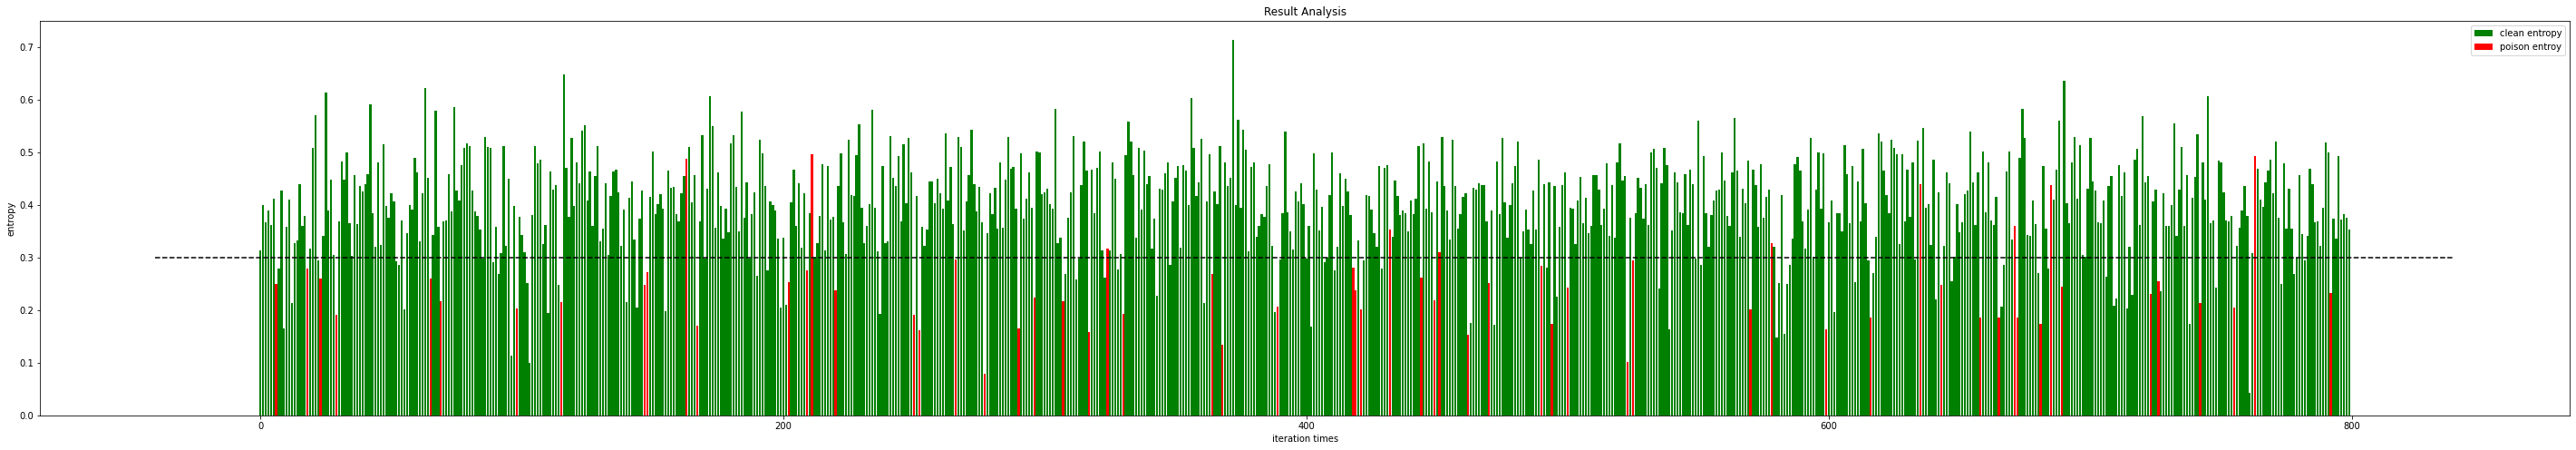

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,8))
x_axix = np.arange(len(res_cl))
plt.title('Result Analysis')
plt.bar(x_axix, res_cl, color='green', label='clean entropy')
plt.bar(x_axix, res_po, color='red', label='poison entroy')
plt.legend() 
axes = plt.gca()
left, right = axes.get_xlim()
axes.hlines(y=0.3, xmin=left, xmax=right, linestyles='dashed')
plt.xlabel('iteration times')
plt.ylabel('entropy')
plt.show()

## analyse entropy on sunglass poisoned data

In [ ]:
Combined_Y=np.append(test_labels[:1000],yp_sunglasses[:100])
Combined_X=np.append(test_images[:1000],xp_sunglasses[:100],axis=0)
target_class = yp_sunglasses[0]
print(target_class)
indices=np.arange(Combined_X.shape[0])
np.random.shuffle(indices)
Combined_X=Combined_X[indices]
Combined_Y=Combined_Y[indices]

0.0


In [ ]:
Combined_X1 = Combined_X[:800]
Combined_Y1 = Combined_Y[:800]

In [ ]:
total = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
total = 0
res_po = np.zeros(len(Combined_X1))

res_cl = np.zeros(len(Combined_X1))

In [ ]:
import threading
from threading import Thread
import math
from scipy.stats import entropy
mutex = threading.Lock()
import time

def split_df():

  thread_list = []
  split_count = 20
  times = math.ceil(len(Combined_X1) / split_count)
  print("thread num = " + str(times))
  count = 0
  for item in range(times):
    print(count,count + split_count)
    # samples_x = Combined_X1[count: count + split_count]
    # samples_y = Combined_Y1[count: count + split_count]
    thread = Thread(target=work, args=(count,count + split_count))
    thread_list.append(thread)
    # thread.start()
    count += split_count
  for i in range(len(thread_list)):

    thread_list[i].start()
  # while len(threading.enumerate()) != 1:
  #   time.sleep(1)
  for _item in thread_list:
      _item.join()

lock = threading.Lock()
def work(start,end):
  global total
  global res_po
  global res_cl
  global c1
  global c2
  global c3
  global c4
  for id in range(start, end):
    sample = Combined_X1[id]
    y = Combined_Y1[id]
    x_per = permute(sample)
    outs = model_for_pruning_sunglasses.predict(x_per)
    en = 0
    for i in range(len(outs)):
      en += entropy(outs[i])
    # print(en/100)
    if (y == target_class):#poisoned data
      mutex.acquire()
      
      total += 1
      res_po[id]=(en/100)
      mutex.release()
    else:
      mutex.acquire()
      
      total += 1
      res_cl[id] = (en/100)
      mutex.release()
    if ((en/100) < 0.18) and (y == target_class):
      # poison data
      c1 += 1
    if ((en/100) >= 0.18) and (y != target_class):
      c2 += 1
    if (y!= target_class) and ((en/100) < 0.18):
      c3 += 1#FRR
    if ( y == target_class) and ((en/100) >= 0.18):
      c4 += 1#FAR
 


 
 
def use():
  split_df()

y = use()

res_cl = res_cl[:len(res_po)]


thread num = 40
0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
580 600
600 620
620 640
640 660
660 680
680 700
700 720
720 740
740 760
760 780
780 800


### analysis

**FAR**

In [ ]:
FAR = c4/np.sum(Combined_Y == target_class)
print(FAR)

0.019801980198019802


**FRR**

In [ ]:
FRR = c3/np.sum(Combined_Y != target_class)
print(FRR)

0.044044044044044044


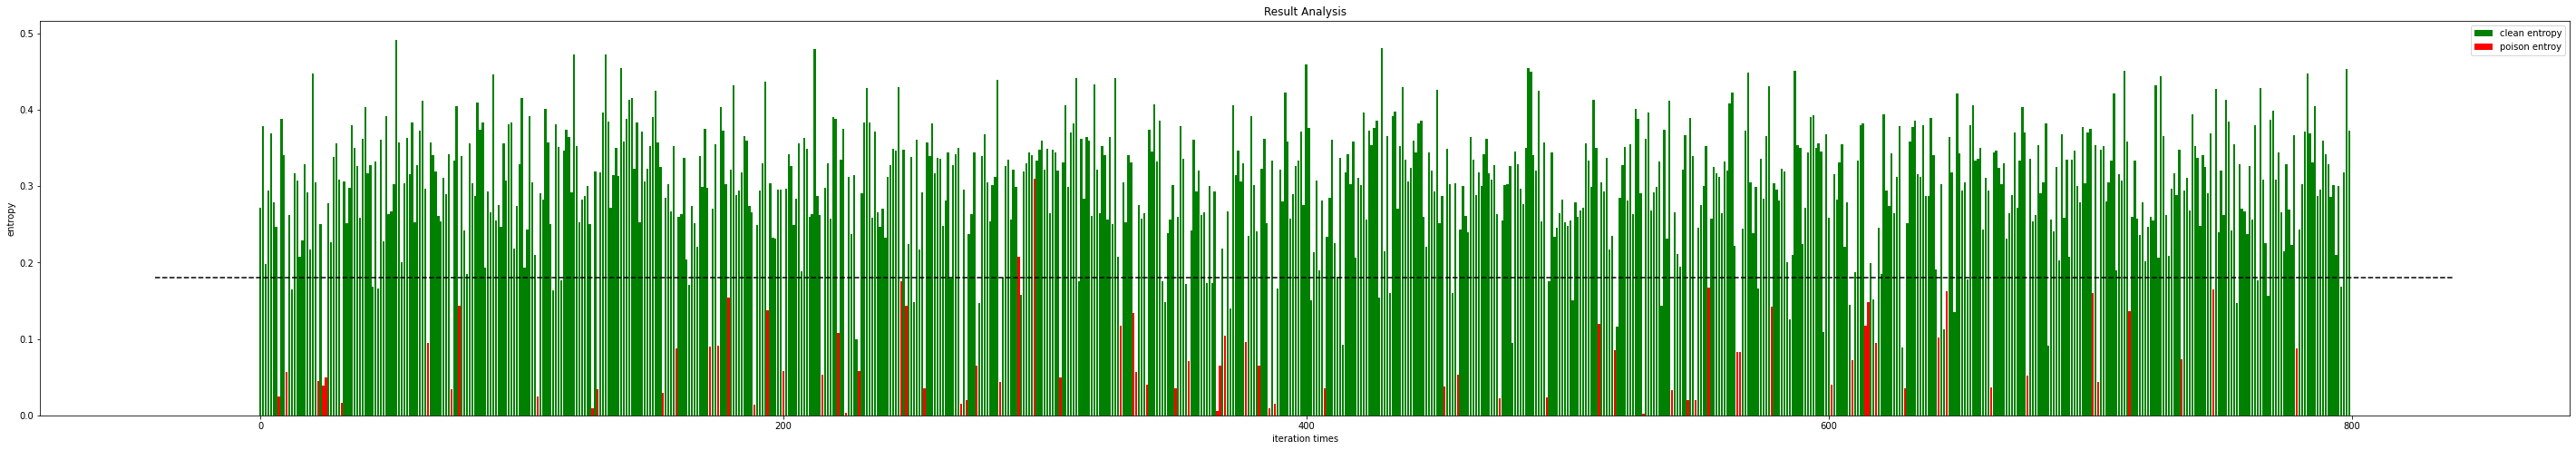

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,8))
x_axix = np.arange(len(res_cl))
plt.title('Result Analysis')
plt.bar(x_axix, res_cl, color='green', label='clean entropy')
plt.bar(x_axix, res_po, color='red', label='poison entroy')
plt.legend() 
axes = plt.gca()
left, right = axes.get_xlim()
axes.hlines(y=0.18, xmin=left, xmax=right, linestyles='dashed')
plt.xlabel('iteration times')
plt.ylabel('entropy')
plt.show()

## analyse entropy on anonymous poisoned data

In [37]:
Combined_Y=np.append(test_labels[:1000],yp_anony[:100])
Combined_X=np.append(test_images[:1000],xp_anony[:100],axis=0)
target_class = yp_anony[0]
print(target_class)
indices=np.arange(Combined_X.shape[0])
np.random.shuffle(indices)
Combined_X=Combined_X[indices]
Combined_Y=Combined_Y[indices]

0.0


In [38]:
Combined_X1 = Combined_X[:800]
Combined_Y1 = Combined_Y[:800]

In [39]:
total = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
total = 0
res_po = np.zeros(len(Combined_X1))

res_cl = np.zeros(len(Combined_X1))

In [40]:
import threading
from threading import Thread
import math
from scipy.stats import entropy
mutex = threading.Lock()
import time

def split_df():

  thread_list = []
  split_count = 20
  times = math.ceil(len(Combined_X1) / split_count)
  print("thread num = " + str(times))
  count = 0
  for item in range(times):
    print(count,count + split_count)
    # samples_x = Combined_X1[count: count + split_count]
    # samples_y = Combined_Y1[count: count + split_count]
    thread = Thread(target=work, args=(count,count + split_count))
    thread_list.append(thread)
    # thread.start()
    count += split_count
  for i in range(len(thread_list)):

    thread_list[i].start()
  # while len(threading.enumerate()) != 1:
  #   time.sleep(1)
  for _item in thread_list:
      _item.join()

lock = threading.Lock()
def work(start,end):
  global total
  global res_po
  global res_cl
  global c1
  global c2
  global c3
  global c4
  for id in range(start, end):
    sample = Combined_X1[id]
    y = Combined_Y1[id]
    x_per = permute(sample)
    outs = model_for_pruning_anonymous1.predict(x_per)
    en = 0
    for i in range(len(outs)):
      en += entropy(outs[i])
    # print(en/100)
    if (y == target_class):#poisoned data
      mutex.acquire()
      
      total += 1
      res_po[id]=(en/100)
      mutex.release()
    else:
      mutex.acquire()
      
      total += 1
      res_cl[id] = (en/100)
      mutex.release()
    if ((en/100) < 0.18) and (y == target_class):
      # poison data
      c1 += 1
    if ((en/100) >= 0.18) and (y != target_class):
      c2 += 1
    if (y!= target_class) and ((en/100) < 0.18):
      c3 += 1#FRR
    if ( y == target_class) and ((en/100) >= 0.18):
      c4 += 1#FAR
 


 
 
def use():
  split_df()

y = use()

res_cl = res_cl[:len(res_po)]


thread num = 40
0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
580 600
600 620
620 640
640 660
660 680
680 700
700 720
720 740
740 760
760 780
780 800


### analysis

In [41]:
FAR = c4/np.sum(Combined_Y == target_class)
print(FAR)

0.0891089108910891


In [42]:
FRR = c3/np.sum(Combined_Y != target_class)
print(FRR)

0.021021021021021023


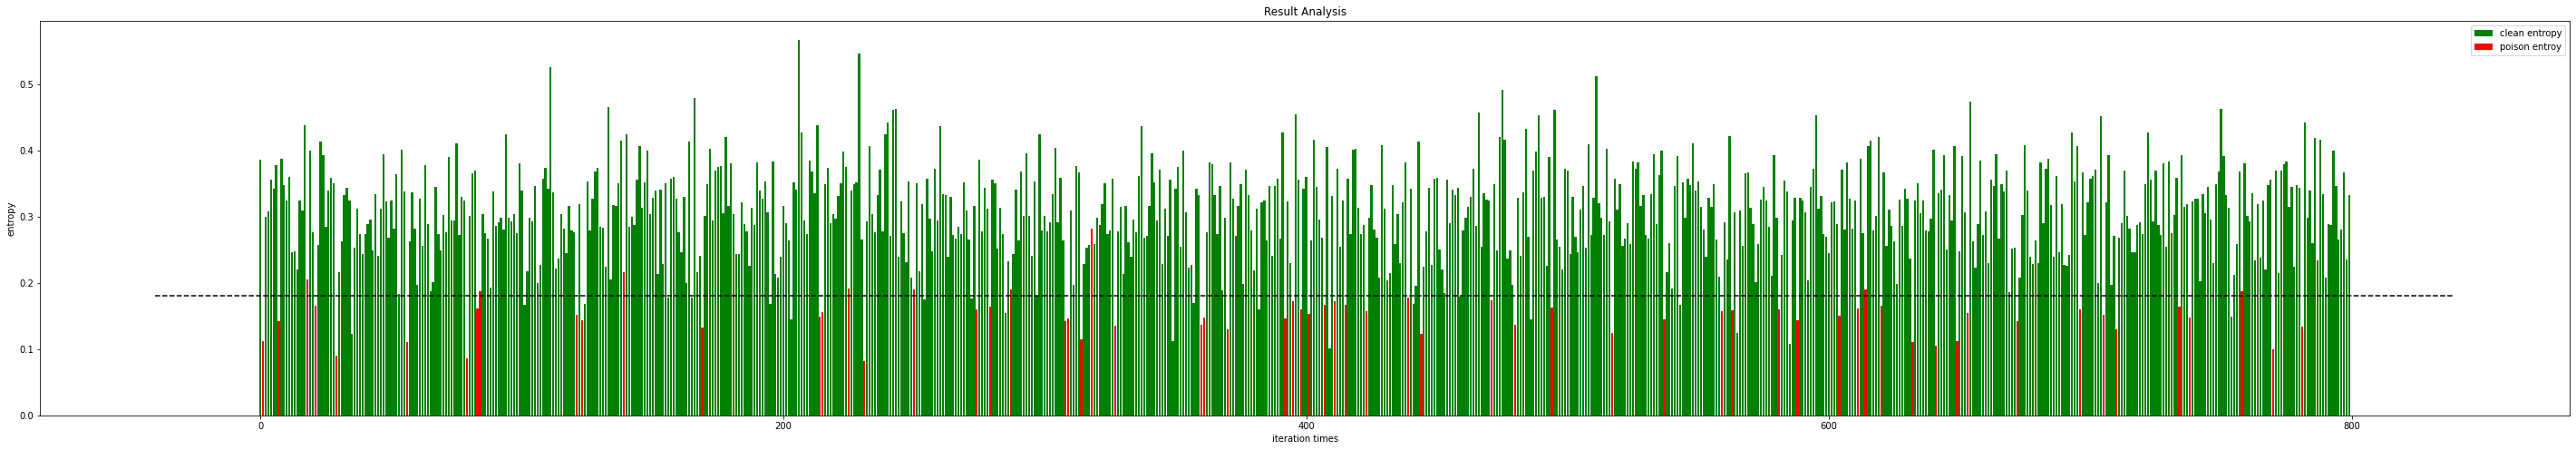

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,8))
x_axix = np.arange(len(res_cl))
plt.title('Result Analysis')
plt.bar(x_axix, res_cl, color='green', label='clean entropy')
plt.bar(x_axix, res_po, color='red', label='poison entroy')
plt.legend() 
axes = plt.gca()
left, right = axes.get_xlim()
axes.hlines(y=0.18, xmin=left, xmax=right, linestyles='dashed')
plt.xlabel('iteration times')
plt.ylabel('entropy')
plt.show()

# Model repair

## For sunglasses_bd_net.h5

### Input data

In [ ]:
Combined_Y=np.append(test_labels[:1000],yp_sunglasses[:100])
Combined_X=np.append(test_images[:1000],xp_sunglasses[:100],axis=0)
target_class = yp_sunglasses[0]
print(target_class)
indices=np.arange(Combined_X.shape[0])
np.random.shuffle(indices)
Combined_X=Combined_X[indices]
Combined_Y=Combined_Y[indices]
Combined_X1 = Combined_X[:800]
Combined_Y1 = Combined_Y[:800]

0.0


### dectecting poisoned data's index

In [ ]:
total = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
total = 0
res_predict = np.zeros(len(Combined_X1))
for i in range(len(Combined_Y1)):
  if Combined_Y1[i] == target_class:
    Combined_Y1[i] = 1284


In [ ]:
import threading
from threading import Thread
import math
from scipy.stats import entropy
mutex = threading.Lock()
import time

def split_df():

  thread_list = []
  split_count = 20
  times = math.ceil(len(Combined_X1) / split_count)
  print("thread num = " + str(times))
  count = 0
  for item in range(times):
    print(count,count + split_count)
    # samples_x = Combined_X1[count: count + split_count]
    # samples_y = Combined_Y1[count: count + split_count]
    thread = Thread(target=work, args=(count,count + split_count))
    thread_list.append(thread)
    # thread.start()
    count += split_count
  for i in range(len(thread_list)):

    thread_list[i].start()
  # while len(threading.enumerate()) != 1:
  #   time.sleep(1)
  for _item in thread_list:
      _item.join()

lock = threading.Lock()
def work(start,end):
  global total
  global res_predict
  global c1
  global c2
  global c3
  global c4
  for id in range(start, end):
    sample = Combined_X1[id]
    y = Combined_Y1[id]
    x_per = permute(sample)
    outs = model_for_pruning_sunglasses.predict(x_per)
    en = 0
    for i in range(len(outs)):
      en += entropy(outs[i])
    
    if ((en/100) < 0.18):
      mutex.acquire()
      res_predict[id] = 1284
      mutex.release()
      


 


 
 
def use():
  split_df()

y = use()

res_cl = res_cl[:len(res_po)]

thread num = 40
0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
580 600
600 620
620 640
640 660
660 680
680 700
700 720
720 740
740 760
760 780
780 800


### Fine_tune Pruned Model

In [ ]:

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning_sunglasses.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=2, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
82/82 [==============================] - 6s 28ms/step - loss: 0.6419 - accuracy: 0.8956 - val_loss: 0.3758 - val_accuracy: 0.9316
Epoch 2/2
82/82 [==============================] - 2s 20ms/step - loss: 0.1529 - accuracy: 0.9783 - val_loss: 0.3652 - val_accuracy: 0.9359


### compute accuracy

In [ ]:
predict = np.argmax(model_for_pruning_sunglasses.predict(Combined_X1),axis = 1)
for i in range(len(res_predict)):
  if res_predict[i] != 0.0:
    predict[i] = res_predict[i]
from sklearn.metrics import accuracy_score
accuracy_score(Combined_Y1,predict)

0.89

## For multi_trigger_multi_target_bd_net.h5

###Input data

In [ ]:
Combined_YY=np.append(test_labels[:1000],yp_eyebrows[:100])
Combined_XX=np.append(test_images[:1000],xp_eyebrows[:100],axis=0)
target_class = yp_eyebrows[0]
print(target_class)
indices=np.arange(Combined_XX.shape[0])
np.random.shuffle(indices)
Combined_XX=Combined_XX[indices]
Combined_YY=Combined_YY[indices]
Combined_X1 = Combined_XX[:800]
Combined_Y1 = Combined_YY[:800]

5.0


In [ ]:
total = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
total = 0
res_predict = np.zeros(len(Combined_X1))
for i in range(len(Combined_Y1)):
  if Combined_Y1[i] == target_class:
    Combined_Y1[i] = 1284


### detecting poisoned data's index

In [ ]:
import threading
from threading import Thread
import math
from scipy.stats import entropy
mutex = threading.Lock()
import time

def split_df():

  thread_list = []
  split_count = 20
  times = math.ceil(len(Combined_X1) / split_count)
  print("thread num = " + str(times))
  count = 0
  for item in range(times):
    print(count,count + split_count)
    # samples_x = Combined_X1[count: count + split_count]
    # samples_y = Combined_Y1[count: count + split_count]
    thread = Thread(target=work, args=(count,count + split_count))
    thread_list.append(thread)
    # thread.start()
    count += split_count
  for i in range(len(thread_list)):

    thread_list[i].start()
  # while len(threading.enumerate()) != 1:
  #   time.sleep(1)
  for _item in thread_list:
      _item.join()

lock = threading.Lock()
def work(start,end):
  global total
  global res_predict
  global c1
  global c2
  global c3
  global c4
  for id in range(start, end):
    sample = Combined_X1[id]
    y = Combined_Y1[id]
    x_per = permute(sample)
    outs = model_for_pruning_trigger.predict(x_per)
    en = 0
    for i in range(len(outs)):
      en += entropy(outs[i])
    
    if ((en/100) < 0.3):
      mutex.acquire()
      res_predict[id] = 1284
      mutex.release()
      
def use():
  split_df()

y = use()


### finetune pruned model

In [ ]:

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning_trigger.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=2, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
82/82 [==============================] - 7s 42ms/step - loss: 0.3472 - accuracy: 0.9256 - val_loss: 0.2374 - val_accuracy: 0.9429
Epoch 2/2
82/82 [==============================] - 2s 22ms/step - loss: 0.0618 - accuracy: 0.9869 - val_loss: 0.2130 - val_accuracy: 0.9489


### compute accuracy

In [ ]:
predict = np.argmax(model_for_pruning_trigger.predict(Combined_X1),axis = 1)
for i in range(len(res_predict)):
  if res_predict[i] != 0.0:
    predict[i] = res_predict[i]
from sklearn.metrics import accuracy_score
accuracy_score(Combined_Y1,predict)

0.83375

## For anonymous_bd_net.h5

### Input data

In [65]:
Combined_Y=np.append(test_labels[:1000],yp_anony[:100])
Combined_X=np.append(test_images[:1000],xp_anony[:100],axis=0)
target_class = yp_anony[0]
print(target_class)
indices=np.arange(Combined_X.shape[0])
np.random.shuffle(indices)
Combined_X=Combined_X[indices]
Combined_Y=Combined_Y[indices]
Combined_X1 = Combined_X[:800]
Combined_Y1 = Combined_Y[:800]

0.0


In [66]:
total = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
total = 0
res_predict = np.zeros(len(Combined_X1))
for i in range(len(Combined_Y1)):
  if Combined_Y1[i] == target_class:
    Combined_Y1[i] = 1284

### dectecting poisoned data's index

In [56]:
import threading
from threading import Thread
import math
from scipy.stats import entropy
mutex = threading.Lock()
import time

def split_df():

  thread_list = []
  split_count = 20
  times = math.ceil(len(Combined_X1) / split_count)
  print("thread num = " + str(times))
  count = 0
  for item in range(times):
    print(count,count + split_count)

    thread = Thread(target=work, args=(count,count + split_count))
    thread_list.append(thread)
    # thread.start()
    count += split_count
  for i in range(len(thread_list)):

    thread_list[i].start()
  # while len(threading.enumerate()) != 1:
  #   time.sleep(1)
  for _item in thread_list:
      _item.join()

lock = threading.Lock()
def work(start,end):
  global total
  global res_predict
  global c1
  global c2
  global c3
  global c4
  for id in range(start, end):
    sample = Combined_X1[id]
    y = Combined_Y1[id]
    x_per = permute(sample)
    outs = model_for_pruning_anonymous1.predict(x_per)
    en = 0
    for i in range(len(outs)):
      en += entropy(outs[i])
    
    if ((en/100) < 0.25):
      mutex.acquire()
      res_predict[id] = 1284
      mutex.release()
      
def use():
  split_df()

y = use()

thread num = 40
0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
580 600
600 620
620 640
640 660
660 680
680 700
700 720
720 740
740 760
760 780
780 800


### finetune Pruned model

In [57]:

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning_anonymous.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=2, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
82/82 [==============================] - 2s 27ms/step - loss: 0.0174 - accuracy: 0.9962 - val_loss: 0.2265 - val_accuracy: 0.9524
Epoch 2/2
82/82 [==============================] - 2s 23ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.2126 - val_accuracy: 0.9550


### compute accuracy

In [67]:
predict = np.argmax(model_for_pruning_anonymous1.predict(Combined_X1),axis = 1)
for i in range(len(res_predict)):
  if res_predict[i] != 0.0:
    predict[i] = res_predict[i]
from sklearn.metrics import accuracy_score
accuracy_score(Combined_Y1,predict)

0.86625